<a href="https://colab.research.google.com/github/taliahtarik/labs/blob/main/04_hedonic_pricing_ASSIGNMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?
7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('/root/airbnb.csv')

# Display the first few rows and column names
print("Column names:", data.columns)
data.head()

Column names: Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood ', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating'],
      dtype='object')


,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [4]:
# Convert 'Price' to numeric, removing any non-numeric characters
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

# Drop rows with missing 'Price' values (since 'Price' is our target variable)
data = data.dropna(subset=['Price'])

# Fill missing values for other columns (using mean or median as appropriate)
data['Review Scores Rating'] = data['Review Scores Rating'].fillna(data['Review Scores Rating'].mean())
data['Beds'] = data['Beds'].fillna(data['Beds'].median())

# Drop columns that are not useful for regression (e.g., text columns)
data = data.drop(columns=['Host Id', 'Host Since', 'Name'])

# Check for any remaining missing values
print("Remaining missing values:", data.isnull().sum())


Remaining missing values: Neighbourhood                    0
Property Type                    3
Review Scores Rating (bin)    8193
Room Type                        0
Zipcode                        134
Beds                             0
Number of Records                0
Number Of Reviews                0
Price                            0
Review Scores Rating             0
dtype: int64


<ipython-input-4-be93e799e8cb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Review Scores Rating'] = data['Review Scores Rating'].fillna(data['Review Scores Rating'].mean())
<ipython-input-4-be93e799e8cb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Beds'] = data['Beds'].fillna(data['Beds'].median())


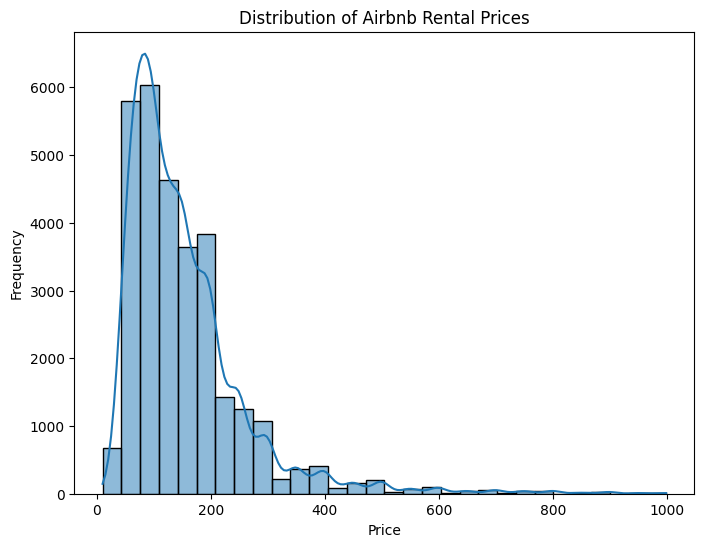

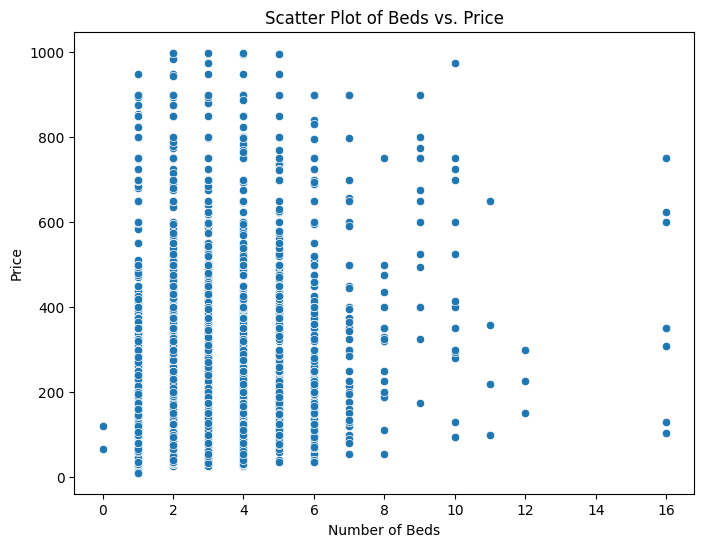

<ipython-input-5-93e25f5b6f7a>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_reviews = data.groupby('Reviews Binned')['Price'].mean()


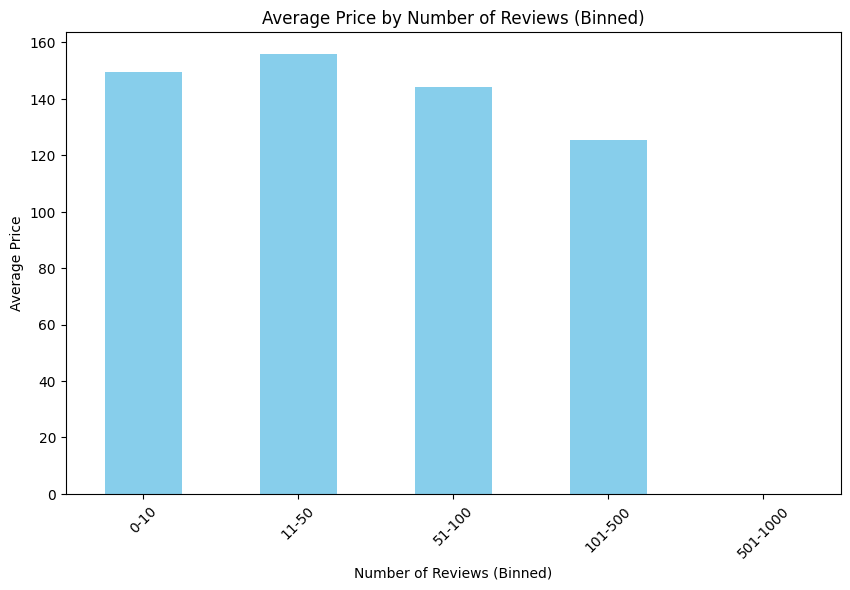

In [5]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Price'], kde=True, bins=30)
plt.title('Distribution of Airbnb Rental Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['Beds'], y=data['Price'])
plt.title('Scatter Plot of Beds vs. Price')
plt.xlabel('Number of Beds')
plt.ylabel('Price')
plt.show()

data['Reviews Binned'] = pd.cut(data['Number Of Reviews'], bins=[0, 10, 50, 100, 500, 1000], labels=['0-10', '11-50', '51-100', '101-500', '501-1000'])
avg_price_by_reviews = data.groupby('Reviews Binned')['Price'].mean()

plt.figure(figsize=(10, 6))
avg_price_by_reviews.plot(kind='bar', color='skyblue')
plt.title('Average Price by Number of Reviews (Binned)')
plt.xlabel('Number of Reviews (Binned)')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()


In [6]:
data = pd.get_dummies(data, drop_first=True)

In [7]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Price'])
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
X = data.drop(columns=['Price'])
y = data['Price']

X = X.fillna(X.mean())

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

simple_model = LinearRegression()
simple_model.fit(X_train, y_train)

y_train_pred = simple_model.predict(X_train)
y_test_pred = simple_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Simple Model - Train RMSE:", train_rmse, "Test RMSE:", test_rmse)
print("Simple Model - Train R^2:", train_r2, "Test R^2:", test_r2)


Simple Model - Train RMSE: 82.17356984458537 Test RMSE: 87.0191617164628
Simple Model - Train R^2: 0.4212080036595901 Test R^2: 0.3997406165207831


In [9]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

complex_model = LinearRegression()
complex_model.fit(X_train_poly, y_train)

y_train_poly_pred = complex_model.predict(X_train_poly)
y_test_poly_pred = complex_model.predict(X_test_poly)

train_poly_rmse = np.sqrt(mean_squared_error(y_train, y_train_poly_pred))
test_poly_rmse = np.sqrt(mean_squared_error(y_test, y_test_poly_pred))
train_poly_r2 = r2_score(y_train, y_train_poly_pred)
test_poly_r2 = r2_score(y_test, y_test_poly_pred)

print("Complex Model - Train RMSE:", train_poly_rmse, "Test RMSE:", test_poly_rmse)
print("Complex Model - Train R^2:", train_poly_r2, "Test R^2:", test_poly_r2)


Complex Model - Train RMSE: 78.74496159900387 Test RMSE: 84.26434276589008
Complex Model - Train R^2: 0.4684993996482184 Test R^2: 0.4371445924843155
